# Gaussian elimination

This Julia notebook allows us to interactively visualize the process of Gaussian elimination.

Recall that the process of [Gaussian elimination](https://en.wikipedia.org/wiki/Gaussian_elimination) involves subtracting rows to turn a matrix $A$ into an [upper triangular matrix](https://en.wikipedia.org/wiki/Triangular_matrix) $U$.  Often we *augment* the matrix with an additional column, representing the right-hand side $b$ of a system of equations $Ax=b$ that we want to solve: by doing the same row operations to both $A$ and $b$, we arrive at an equivalent equation $Ux=c$ that is easy to solve by *backsubstitution* (solving for one variable at a time, working from the last row to the top row).

For example, suppose we are solving:

$$
Ax = 
\begin{pmatrix}
1 & 3 & 1  \\
1 & 1 & -1  \\
3 & 11 & 6 
\end{pmatrix} x = 
\begin{pmatrix}
9 \\
1 \\
35
\end{pmatrix} = b
$$

We would perform the following elimination process.

$$
\left[\begin{array}{rrr|r}
1 & 3 & 1 & 9 \\
1 & 1 & -1 & 1 \\
3 & 11 & 6 & 35
\end{array}\right]\to
\left[\begin{array}{rrr|r}
1 & 3 & 1 & 9 \\
0 & -2 & -2 & -8 \\
0 & 2 & 3 & 8
\end{array}\right]\to
\left[\begin{array}{rrr|r}
1 & 3 & 1 & 9 \\
0 & -2 & -2 & -8 \\
0 & 0 & 1 & 0
\end{array}\right]
$$

It is much more fun to let the computer do the arithmetic than to crunch through it ourselves on the blackboard, but usually the computer does things *too* quickly (and it often does some re-ordering of the rows that makes it harder to follow what is going on).  For example, in Julia, we can solve the above system of equations by simply:

In [1]:
A = [1 3  1
     1 1 -1
     3 11 6]

3×3 Array{Int64,2}:
 1   3   1
 1   1  -1
 3  11   6

In [2]:
b = [9, 1, 35]

3-element Array{Int64,1}:
  9
  1
 35

In [3]:
x = A \ b # solves Ax = b by (essentially) Gaussian elimination

3-element Array{Float64,1}:
 -3.0
  4.0
  0.0

If we want to see the matrix $U$ from above, we use the fact (covered soon in 18.06) that Gaussian elimination is really "LU" factorization, performed by the built-in function `lu`. By default, however, "serious" computer implementations of this process automatically re-order the rows to reduce the effect of roundoff errors, so we need to pass an extra option that tells Julia not to do this.  (You should *not* normally do this, except for learning exercises.)

In [4]:
# LU factorization (Gaussian elimination) of the augumented matrix [A b], 
# passing the undocumented option Val{false} to prevent row re-ordering
L, U = lu([A b], Val{false}) 
U # just show U

3×4 Array{Float64,2}:
 1.0   3.0   1.0   9.0
 0.0  -2.0  -2.0  -8.0
 0.0   0.0   1.0   0.0

However, it would be nice to show the individual steps of this process.  This requires some programming.

# Code to interactively visualize Gaussian elimination

The following is some slightly tricky code that lets us visualize the process of Gaussian elimination in Julia.  It takes advantage of the [Interact](https://github.com/JuliaGizmos/Interact.jl) package in Julia, which allows us to easily create interactive displays using sliders, pushbuttons, and other widgets.

Implementing this is **not really a beginner exercise** for new Julia programmers, though it is fairly straightforward for people who are used to Julia.  It involves defining our own type to control display, our own implementation of Gaussian elimination that allows us to stop partway through, and using the Interact package to create interactive widgets.

You can skip this part if you aren't ready for the programming details.

In [5]:
"""
TwoMatrices is just a wrapper type around two matrices or vectors with the same
number of rows, so that they can be displayed side-by-side with a title and
and arrow pointing from left to right.
"""
type TwoMatrices
    left::AbstractVecOrMat
    right::AbstractVecOrMat
    title::AbstractString
    function TwoMatrices(left, right, title="")
        size(left,1) == size(right,1) || throw(DimensionMismatch("two matrices must have same # rows"))
        return new(left, right, title)
    end
end
function Base.show(io::IO, ::MIME"text/plain", x::TwoMatrices)
    isempty(x.title) || println(io, x.title)
    m = size(x.left, 1)
    s = [Text(" "^10) for i in 1:m]
    s[(m+1)÷2] = Text("   --->   ")
    Base.showarray(io, [x.left s x.right], false; header=false)
end

"""
    naive_gauss(A, [step])

Given a matrix `A`, performs Gaussian elimination to convert
`A` into an upper-triangular matrix `U`.

This implementation is "naive" because it *never re-orders the rows*.
(It will obviously fail if a zero pivot is encountered.)

If the optional `step` argument is supplied, only performs `step`
steps of Gaussian elimination.

Returns `(U, row, col, factor)`, where `row` and `col` are the
row and column of the last step performed, while `factor`
is the last factor multiplying the pivot row.
"""
function naive_gauss(A, step=typemax(Int))
    m = size(A,1) # number of rows
    factor = A[1,1]/A[1,1]
    step ≤ 0 && return (A, 1, 1, factor)
    U = copy!(similar(A, typeof(factor)), A)
    for j = 1:m   # loop over m columns
        for i = j+1:m   # loop over rows below the pivot row j
            # subtract a multiple of the pivot row (j)
            # from the current row (i) to cancel U[i,j] = Uᵢⱼ:
            factor = -U[i,j]/U[j,j]
            U[i,:] = U[i,:] + U[j,:] * factor
            step -= 1
            step ≤ 0 && return (U, i, j, factor)
        end
    end
    return U, m, m, factor
end

naive_gauss

In [6]:
using Interact

# For display, I only want to show 3 decimal places of floating-point values,
# but I want to show integers and similar types exactly, so I define a little
# function to do this rounding
shorten(x::AbstractFloat) = round(x, 3)
shorten(x) = x # leave non floating-point values as-is

# create an interactive widget to visualize the Gaussian-elimination process for the matrix A.
function visualize_gauss(A)
    m = size(A, 1)
    @manipulate for step in slider(1:(m*(m-1))÷2, value=1, label="gauss step")
        Uprev, = naive_gauss(A, step-1)
        U, row, col, factor = naive_gauss(A, step)
        pivot = U[col,col]
        TwoMatrices(shorten.(Uprev), shorten.(U), "Gaussian elimination for column $col with pivot $pivot: add $(shorten(factor)) * (row $col) to (row $row)")
    end
end

visualize_gauss (generic function with 1 method)

# Gaussian elimination examples

Now, let's use this machinery to interact with some examples, starting with our $3 \times 3$ matrix from above:

In [7]:
visualize_gauss([A b])

Interact.Slider{Int64}(Signal{Int64}(1, nactions=1),"gauss step",1,1:3,"horizontal",true,"d",true)

Gaussian elimination for column 1 with pivot 1.0: add -1.0 * (row 1) to (row 2)
 1   3   1   9              1.0   3.0   1.0   9.0
 1   1  -1   1     --->     0.0  -2.0  -2.0  -8.0
 3  11   6  35              3.0  11.0   6.0  35.0

In [8]:
visualize_gauss(rand(-9:9,5,5))

Interact.Slider{Int64}(Signal{Int64}(1, nactions=1),"gauss step",1,1:10,"horizontal",true,"d",true)

Gaussian elimination for column 1 with pivot 3.0: add -1.0 * (row 1) to (row 2)
  3   0  -3   8   7               3.0   0.0  -3.0    8.0   7.0
  3   2  -3  -7   6               0.0   2.0   0.0  -15.0  -1.0
 -1   9  -3  -4   3     --->     -1.0   9.0  -3.0   -4.0   3.0
 -7  -5  -7   3   2              -7.0  -5.0  -7.0    3.0   2.0
 -3  -2  -9   1  -8              -3.0  -2.0  -9.0    1.0  -8.0

Of course, because we are not re-ordering the rows, this process can go horribly wrong, most obviously if a zero pivot is encountered:

In [9]:
Abad = [-3   5   5   3  -7
         3  -5   8  -8  -6
         8   2   8   2  -8
        -6  -2   6   4  -8
        -8   4  -6  -1   8]
visualize_gauss(Abad)

Interact.Slider{Int64}(Signal{Int64}(1, nactions=1),"gauss step",1,1:10,"horizontal",true,"d",true)

Gaussian elimination for column 1 with pivot -3.0: add 1.0 * (row 1) to (row 2)
 -3   5   5   3  -7              -3.0   5.0   5.0   3.0   -7.0
  3  -5   8  -8  -6               0.0   0.0  13.0  -5.0  -13.0
  8   2   8   2  -8     --->      8.0   2.0   8.0   2.0   -8.0
 -6  -2   6   4  -8              -6.0  -2.0   6.0   4.0   -8.0
 -8   4  -6  -1   8              -8.0   4.0  -6.0  -1.0    8.0

But this matrix is not actually singular:

In [10]:
det(Abad)

19211.999999999996

So we can fix the problem just by re-ordering the rows, e.g. swapping the first and last rows:

In [11]:
Aok = [-8   4  -6  -1   8
        3  -5   8  -8  -6
        8   2   8   2  -8
       -6  -2   6   4  -8
       -3   5   5   3  -7]
visualize_gauss(Aok)

Interact.Slider{Int64}(Signal{Int64}(1, nactions=1),"gauss step",1,1:10,"horizontal",true,"d",true)

Gaussian elimination for column 1 with pivot -8.0: add 0.375 * (row 1) to (row 2)
 -8   4  -6  -1   8              -8.0   4.0  -6.0   -1.0     8.0
  3  -5   8  -8  -6               0.0  -3.5   5.75  -8.375  -3.0
  8   2   8   2  -8     --->      8.0   2.0   8.0    2.0    -8.0
 -6  -2   6   4  -8              -6.0  -2.0   6.0    4.0    -8.0
 -3   5   5   3  -7              -3.0   5.0   5.0    3.0    -7.0

## A bigger example

We quickly run out of space for displaying matrices as text, but we can visualize the process for larger matrices by using images, with the PyPlot package (a wrapper around the Python Matplotlib library):

In [12]:
using PyPlot

Interact.Slider{Int64}(Signal{Int64}(2, nactions=1),"gauss step",2,0:50:4950,"horizontal",true,"d",true)

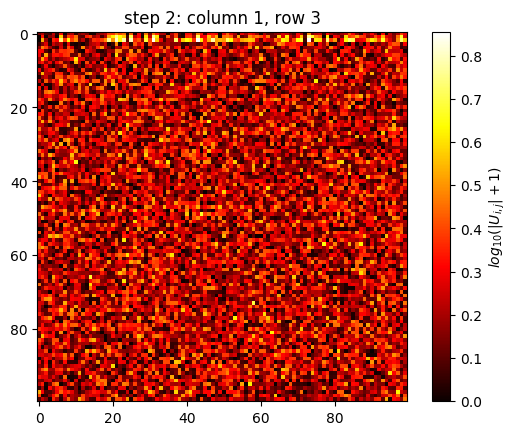

In [13]:
m = 100
Abig = randn(m,m)
fig = figure()
nsteps = (m*(m-1))÷2
@manipulate for step in slider(0:50:nsteps, value=2, label="gauss step")
    withfig(fig) do
        U, row, col = naive_gauss(Abig, step)
        # I had to experiment a little to find a nice way to plot this
        imshow(log10.(abs.(U) .+ 1), cmap="hot")
        title("step $step: column $col, row $row")
        colorbar(label=L"log_{10}(|U_{i,j}| + 1)")
    end
end

Note that it takes a *lot* more steps of Gaussian elimination for a $100 \times 100$ matrix (4950 steps) than for a $5 \times 5$ matrix (10 steps).  Later on in 18.06, we will analyze the computational cost of Gaussian elimination and how it scales with the size of the matrix (in computer science, this is known as the [complexity](https://en.wikipedia.org/wiki/Computational_complexity_theory) of the algorithm).